In [1]:
import sys
sys.path.append('../')

from model_runner import ModelRunner
from DBPN_copied import DBPN
from custom_image_dataset import CustomImageDataset
from torch.utils.data import DataLoader
from torchvision import transforms
from PIL import Image
import torch
torch.cuda.empty_cache()
from torch import nn
from image_helper import ImageHelper
import image_patches
import os
import pandas as pd
from GaussianNoise import AddGaussianNoise

In [2]:
# DATASET_ROOT="../datasets/"
TRAIN_DATASET_NAME = "../datasets/TRAIN_Flick2k_DIV2K/"
VALIDATION_DATASET_NAME = "../datasets/VALIDATION_Flickr2K_DIV2K/"
# TRAIN_DATASET_NAME = "../datasets/set14/"
# VALIDATION_DATASET_NAME = "../datasets/Set5/"

In [3]:
PATCH_SIZE = 128 # 32 * 4
# PATCHES_PER_IMAGE_TRAIN = 20
PATCHES_PER_IMAGE_TRAIN = 30 #######
# PATCHES_PER_IMAGE_TRAIN = 50 ##
# PATCHES_PER_IMAGE_TRAIN = 4
# PATCHES_PER_IMAGE_VALIDATION = 4
PATCHES_PER_IMAGE_VALIDATION = 20 #######
# PATCHES_PER_IMAGE_VALIDATION = 1
# PATCHES_PER_IMAGE_TRAIN = 45
# PATCHES_PER_IMAGE_VALIDATION = 12 # 45 // 4

In [4]:
TRAIN_DATA_PATH = f"{TRAIN_DATASET_NAME}_{PATCH_SIZE}_{PATCH_SIZE}_number={PATCHES_PER_IMAGE_TRAIN}"
VALIDATION_DATA_PATH =  f"{VALIDATION_DATASET_NAME}_{PATCH_SIZE}_{PATCH_SIZE}_number={PATCHES_PER_IMAGE_VALIDATION}"
print('TRAIN_DATA_PATH =', TRAIN_DATA_PATH)
print('VALIDATION_DATA_PATH =', VALIDATION_DATA_PATH)

TRAIN_DATA_PATH = ../datasets/TRAIN_Flick2k_DIV2K/_128_128_number=30
VALIDATION_DATA_PATH = ../datasets/VALIDATION_Flickr2K_DIV2K/_128_128_number=20


In [5]:
# image_patches.create_valid_image_patches(f"{TRAIN_DATASET_NAME}", (PATCH_SIZE, PATCH_SIZE, 3), TRAIN_DATA_PATH, PATCHES_PER_IMAGE_TRAIN)
# image_patches.create_valid_image_patches(f"{VALIDATION_DATASET_NAME}", (PATCH_SIZE, PATCH_SIZE, 3), VALIDATION_DATA_PATH, PATCHES_PER_IMAGE_VALIDATION)

In [6]:
%%time

SCALE_FACTOR=4

transform_x = transforms.Compose([
    transforms.Resize((PATCH_SIZE // SCALE_FACTOR, PATCH_SIZE // SCALE_FACTOR), interpolation=Image.BICUBIC),
    # AddGaussianNoise(0., 0.1),
])

transform_y = transforms.Compose([
    transforms.CenterCrop((PATCH_SIZE, PATCH_SIZE))
])

# Set up the data loaders
train_data_set = CustomImageDataset(
    img_dir=TRAIN_DATA_PATH, transform=transform_x, target_transform=transform_y, tensor_size=PATCH_SIZE)
validation_data_set = CustomImageDataset(
    img_dir=VALIDATION_DATA_PATH, transform=transform_x, target_transform=transform_y, tensor_size=PATCH_SIZE)

# Report split sizes
print('Training set has {} instances'.format(len(train_data_set)))
print('Validation set has {} instances'.format(len(validation_data_set)))

Creating Dataset based on folder: ../datasets/TRAIN_Flick2k_DIV2K/_128_128_number=30


 87%|████████▋ | 2554/2920 [00:58<00:07, 45.89it/s]

Error loading image file: ../datasets/TRAIN_Flick2k_DIV2K/_128_128_number=30/patches/000658_patch/patch_8.png. Reason: Out of bound read in decode_png. Probably, the input image is corrupted


100%|██████████| 2920/2920 [01:06<00:00, 43.79it/s]


Creating Dataset based on folder: ../datasets/TRAIN_Flick2k_DIV2K/_128_128_number=30
Creating Dataset based on folder: ../datasets/VALIDATION_Flickr2K_DIV2K/_128_128_number=20


100%|██████████| 630/630 [00:09<00:00, 68.03it/s]


Creating Dataset based on folder: ../datasets/VALIDATION_Flickr2K_DIV2K/_128_128_number=20
Training set has 87539 instances
Validation set has 12592 instances
CPU times: user 1h 21s, sys: 14.4 s, total: 1h 35s
Wall time: 1min 23s


In [7]:
# image_helper = ImageHelper()
# image =  Image.open('../datasets/Set5/baby.png')
# image_tensor = image_helper.image_to_tensor(image)
# image_tensor = image_tensor + torch.randn(image_tensor.shape)*0.1
# image_helper.show_tensor_as_image(image_tensor)

In [8]:
%%time

# https://towardsdatascience.com/7-tips-for-squeezing-maximum-performance-from-pytorch-ca4a40951259
pin_memory = False
batch_size = round(1*(2**6))

train_dataloader = DataLoader(train_data_set, batch_size=batch_size, shuffle=True, pin_memory=pin_memory)
validation_dataloader = DataLoader(validation_data_set, batch_size=batch_size, pin_memory=pin_memory)

CPU times: user 1.2 s, sys: 376 ms, total: 1.58 s
Wall time: 1.58 s


In [9]:
# image_helper = ImageHelper()
# i = 0
# for x, y in train_dataloader:
#     i += 1
#     if i > 2:
#         break
#     image_helper.show_tensor_as_image(x[0])
#     image_helper.show_tensor_as_image(y[0])
#     print(x.shape)
#     print(y.shape)
#     break

In [10]:
# The learning rate is initialized to 1e − 4 for all layers and decrease by a factor of 10 for every 5 × 105 iterations for total 106 iterations.
lr = 2.5e-3
model_betas = (0.9, 0.999)
device = torch.device('cuda:0')

# Total number of epochs
epochs = 25

model = DBPN(num_channels=3, base_filter=64,  feat = 256, num_stages=7, scale_factor=4).to(device)
model_runner = ModelRunner()

# For optimization, we use Adam with momentum to 0.9 and weight decay to 1e−4.
optimizer = torch.optim.Adam(model.parameters(), lr=lr, betas=model_betas, weight_decay=1e-4)
# scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer,
#                               T_max = epochs, # Maximum number of iterations.
#                              eta_min = 1e-6) # Minimum learning rate.

In [11]:
%%time
model_runner.train(
    model=model,
    train_dataloader=train_dataloader,
    validation_dataloader=validation_dataloader,
    optimizer=optimizer,
    epochs=epochs,
    scheduler=None,
    loss_fn=nn.MSELoss(),
    save_file_path='./DBPN-real-run-medium-dataset-no-noise-cuda-0.txt'
)


epoch 0
-------------------------------


Training on 87539 samples...
Batch size: 64
Number of batches: 1368


  0%|          | 0/1368 [00:00<?, ?it/s]/home/pedrovelozo/TCC-Pedro-Velozo-ENG1132/env/lib/python3.8/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
100%|██████████| 1368/1368 [07:08<00:00,  3.19it/s]


Training Error: 
 Avg loss: 188816909083818295296.000000 



100%|██████████| 197/197 [00:23<00:00,  8.40it/s]


Validation Error: 
 Avg loss: 4687628082566264.000000 

Epoch: 0
Time: 454.3056478500366
Learning rate: 0.0025
Train loss: 1.888169090838183e+20
Validation loss: 4687628082566264.0
Elapsed time: 454.30574107170105

epoch 1
-------------------------------
Training on 87539 samples...
Batch size: 64
Number of batches: 1368


100%|██████████| 1368/1368 [07:08<00:00,  3.20it/s]


Training Error: 
 Avg loss: 2257671630845509.000000 



100%|██████████| 197/197 [00:23<00:00,  8.40it/s]


Validation Error: 
 Avg loss: 992047365692899.375000 

Epoch: 1
Time: 454.1449308395386
Learning rate: 0.0025
Train loss: 2257671630845509.0
Validation loss: 992047365692899.4
Elapsed time: 454.145015001297

epoch 2
-------------------------------
Training on 87539 samples...
Batch size: 64
Number of batches: 1368


100%|██████████| 1368/1368 [07:08<00:00,  3.19it/s]


Training Error: 
 Avg loss: 493705230513732.875000 



100%|██████████| 197/197 [00:23<00:00,  8.41it/s]


Validation Error: 
 Avg loss: 154320197728224.812500 

Epoch: 2
Time: 454.2116641998291
Learning rate: 0.0025
Train loss: 493705230513732.9
Validation loss: 154320197728224.8
Elapsed time: 454.2117500305176

epoch 3
-------------------------------
Training on 87539 samples...
Batch size: 64
Number of batches: 1368


100%|██████████| 1368/1368 [07:08<00:00,  3.19it/s]


Training Error: 
 Avg loss: 121776363442870.640625 



100%|██████████| 197/197 [00:23<00:00,  8.41it/s]


Validation Error: 
 Avg loss: 72001842971289.343750 

Epoch: 3
Time: 454.1825888156891
Learning rate: 0.0025
Train loss: 121776363442870.64
Validation loss: 72001842971289.34
Elapsed time: 454.18267464637756

epoch 4
-------------------------------
Training on 87539 samples...
Batch size: 64
Number of batches: 1368


100%|██████████| 1368/1368 [07:08<00:00,  3.20it/s]


Training Error: 
 Avg loss: 58850766804884.210938 



100%|██████████| 197/197 [00:23<00:00,  8.41it/s]


Validation Error: 
 Avg loss: 37257239930952.773438 

Epoch: 4
Time: 454.0034432411194
Learning rate: 0.0025
Train loss: 58850766804884.21
Validation loss: 37257239930952.77
Elapsed time: 454.0035243034363

epoch 5
-------------------------------
Training on 87539 samples...
Batch size: 64
Number of batches: 1368


100%|██████████| 1368/1368 [07:07<00:00,  3.20it/s]


Training Error: 
 Avg loss: 28005139086976.750000 



100%|██████████| 197/197 [00:23<00:00,  8.41it/s]


Validation Error: 
 Avg loss: 14915279873704.933594 

Epoch: 5
Time: 453.96739745140076
Learning rate: 0.0025
Train loss: 28005139086976.75
Validation loss: 14915279873704.934
Elapsed time: 453.96747732162476

epoch 6
-------------------------------
Training on 87539 samples...
Batch size: 64
Number of batches: 1368


100%|██████████| 1368/1368 [07:07<00:00,  3.20it/s]


Training Error: 
 Avg loss: 12226185202682.011719 



100%|██████████| 197/197 [00:23<00:00,  8.42it/s]


Validation Error: 
 Avg loss: 7390412860545.949219 

Epoch: 6
Time: 453.9023470878601
Learning rate: 0.0025
Train loss: 12226185202682.012
Validation loss: 7390412860545.949
Elapsed time: 453.90243315696716

epoch 7
-------------------------------
Training on 87539 samples...
Batch size: 64
Number of batches: 1368


100%|██████████| 1368/1368 [07:07<00:00,  3.20it/s]


Training Error: 
 Avg loss: 6869198603485.567383 



100%|██████████| 197/197 [00:23<00:00,  8.42it/s]


Validation Error: 
 Avg loss: 3813146077090.436523 

Epoch: 7
Time: 453.7628490924835
Learning rate: 0.0025
Train loss: 6869198603485.567
Validation loss: 3813146077090.4365
Elapsed time: 453.7629306316376

epoch 8
-------------------------------
Training on 87539 samples...
Batch size: 64
Number of batches: 1368


100%|██████████| 1368/1368 [07:07<00:00,  3.20it/s]


Training Error: 
 Avg loss: 3428621106960.467773 



100%|██████████| 197/197 [00:23<00:00,  8.42it/s]


Validation Error: 
 Avg loss: 1587484595236.385742 

Epoch: 8
Time: 453.7998640537262
Learning rate: 0.0025
Train loss: 3428621106960.468
Validation loss: 1587484595236.3857
Elapsed time: 453.7999498844147

epoch 9
-------------------------------
Training on 87539 samples...
Batch size: 64
Number of batches: 1368


100%|██████████| 1368/1368 [07:07<00:00,  3.20it/s]


Training Error: 
 Avg loss: 1639673774870.456055 



100%|██████████| 197/197 [00:23<00:00,  8.43it/s]


Validation Error: 
 Avg loss: 859788229491.654785 

Epoch: 9
Time: 453.49570298194885
Learning rate: 0.0025
Train loss: 1639673774870.456
Validation loss: 859788229491.6548
Elapsed time: 453.49578881263733

epoch 10
-------------------------------
Training on 87539 samples...
Batch size: 64
Number of batches: 1368


100%|██████████| 1368/1368 [07:07<00:00,  3.20it/s]


Training Error: 
 Avg loss: 807830320445.380127 



100%|██████████| 197/197 [00:23<00:00,  8.42it/s]


Validation Error: 
 Avg loss: 388160539403.695435 

Epoch: 10
Time: 453.6383786201477
Learning rate: 0.0025
Train loss: 807830320445.3801
Validation loss: 388160539403.69543
Elapsed time: 453.63846588134766

epoch 11
-------------------------------
Training on 87539 samples...
Batch size: 64
Number of batches: 1368


100%|██████████| 1368/1368 [07:07<00:00,  3.20it/s]


Training Error: 
 Avg loss: 325850740083.274841 



100%|██████████| 197/197 [00:23<00:00,  8.41it/s]


Validation Error: 
 Avg loss: 143473852748.670044 

Epoch: 11
Time: 453.82651019096375
Learning rate: 0.0025
Train loss: 325850740083.27484
Validation loss: 143473852748.67004
Elapsed time: 453.82659101486206

epoch 12
-------------------------------
Training on 87539 samples...
Batch size: 64
Number of batches: 1368


100%|██████████| 1368/1368 [07:07<00:00,  3.20it/s]


Training Error: 
 Avg loss: 138571821379.368408 



100%|██████████| 197/197 [00:23<00:00,  8.42it/s]


Validation Error: 
 Avg loss: 67755045581.319794 

Epoch: 12
Time: 453.61192750930786
Learning rate: 0.0025
Train loss: 138571821379.3684
Validation loss: 67755045581.31979
Elapsed time: 453.61200881004333

epoch 13
-------------------------------
Training on 87539 samples...
Batch size: 64
Number of batches: 1368


100%|██████████| 1368/1368 [07:07<00:00,  3.20it/s]


Training Error: 
 Avg loss: 73465094744.327484 



100%|██████████| 197/197 [00:23<00:00,  8.43it/s]


Validation Error: 
 Avg loss: 38053492964.710663 

Epoch: 13
Time: 453.443124294281
Learning rate: 0.0025
Train loss: 73465094744.32748
Validation loss: 38053492964.71066
Elapsed time: 453.443208694458

epoch 14
-------------------------------
Training on 87539 samples...
Batch size: 64
Number of batches: 1368


100%|██████████| 1368/1368 [07:07<00:00,  3.20it/s]


Training Error: 
 Avg loss: 41522548182.830406 



100%|██████████| 197/197 [00:23<00:00,  8.42it/s]


Validation Error: 
 Avg loss: 22253477539.736042 

Epoch: 14
Time: 453.66088342666626
Learning rate: 0.0025
Train loss: 41522548182.83041
Validation loss: 22253477539.736042
Elapsed time: 453.66096663475037

epoch 15
-------------------------------
Training on 87539 samples...
Batch size: 64
Number of batches: 1368


100%|██████████| 1368/1368 [07:07<00:00,  3.20it/s]


Training Error: 
 Avg loss: 22488343828.210526 



100%|██████████| 197/197 [00:23<00:00,  8.43it/s]


Validation Error: 
 Avg loss: 13325686118.659899 

Epoch: 15
Time: 453.6959385871887
Learning rate: 0.0025
Train loss: 22488343828.210526
Validation loss: 13325686118.659899
Elapsed time: 453.6960217952728

epoch 16
-------------------------------
Training on 87539 samples...
Batch size: 64
Number of batches: 1368


100%|██████████| 1368/1368 [07:07<00:00,  3.20it/s]


Training Error: 
 Avg loss: 11894003564.538012 



100%|██████████| 197/197 [00:23<00:00,  8.40it/s]


Validation Error: 
 Avg loss: 7730395985.868020 

Epoch: 16
Time: 453.8630986213684
Learning rate: 0.0025
Train loss: 11894003564.538012
Validation loss: 7730395985.86802
Elapsed time: 453.86318373680115

epoch 17
-------------------------------
Training on 87539 samples...
Batch size: 64
Number of batches: 1368


100%|██████████| 1368/1368 [07:08<00:00,  3.20it/s]


Training Error: 
 Avg loss: 6520114453.707603 



100%|██████████| 197/197 [00:23<00:00,  8.41it/s]


Validation Error: 
 Avg loss: 4390696844.345178 

Epoch: 17
Time: 454.13482117652893
Learning rate: 0.0025
Train loss: 6520114453.7076025
Validation loss: 4390696844.345178
Elapsed time: 454.13490653038025

epoch 18
-------------------------------
Training on 87539 samples...
Batch size: 64
Number of batches: 1368


100%|██████████| 1368/1368 [07:07<00:00,  3.20it/s]


Training Error: 
 Avg loss: 3666442283.602339 



100%|██████████| 197/197 [00:23<00:00,  8.41it/s]


Validation Error: 
 Avg loss: 2451841438.538071 

Epoch: 18
Time: 453.73660588264465
Learning rate: 0.0025
Train loss: 3666442283.6023393
Validation loss: 2451841438.538071
Elapsed time: 453.73669147491455

epoch 19
-------------------------------
Training on 87539 samples...
Batch size: 64
Number of batches: 1368


100%|██████████| 1368/1368 [07:07<00:00,  3.20it/s]


Training Error: 
 Avg loss: 2042037005.380117 



100%|██████████| 197/197 [00:23<00:00,  8.41it/s]


Validation Error: 
 Avg loss: 1302889282.274112 

Epoch: 19
Time: 453.5837104320526
Learning rate: 0.0025
Train loss: 2042037005.380117
Validation loss: 1302889282.2741117
Elapsed time: 453.5837914943695

epoch 20
-------------------------------
Training on 87539 samples...
Batch size: 64
Number of batches: 1368


100%|██████████| 1368/1368 [07:07<00:00,  3.20it/s]


Training Error: 
 Avg loss: 93489530196319666176.000000 



100%|██████████| 197/197 [00:23<00:00,  8.41it/s]


Validation Error: 
 Avg loss: 545539686843041984.000000 

Epoch: 20
Time: 453.8571984767914
Learning rate: 0.0025
Train loss: 9.348953019631967e+19
Validation loss: 5.45539686843042e+17
Elapsed time: 453.85728907585144

epoch 21
-------------------------------
Training on 87539 samples...
Batch size: 64
Number of batches: 1368


100%|██████████| 1368/1368 [07:07<00:00,  3.20it/s]


Training Error: 
 Avg loss: 106694669605494352.000000 



100%|██████████| 197/197 [00:23<00:00,  8.41it/s]


Validation Error: 
 Avg loss: 30723512623954636.000000 

Epoch: 21
Time: 453.7177023887634
Learning rate: 0.0025
Train loss: 1.0669466960549435e+17
Validation loss: 3.0723512623954636e+16
Elapsed time: 453.7177963256836

epoch 22
-------------------------------
Training on 87539 samples...
Batch size: 64
Number of batches: 1368


100%|██████████| 1368/1368 [07:07<00:00,  3.20it/s]


Training Error: 
 Avg loss: 17174013026702964.000000 



100%|██████████| 197/197 [00:23<00:00,  8.43it/s]


Validation Error: 
 Avg loss: 9182874619217868.000000 

Epoch: 22
Time: 453.6498599052429
Learning rate: 0.0025
Train loss: 1.7174013026702964e+16
Validation loss: 9182874619217868.0
Elapsed time: 453.649950504303

epoch 23
-------------------------------
Training on 87539 samples...
Batch size: 64
Number of batches: 1368


100%|██████████| 1368/1368 [07:07<00:00,  3.20it/s]


Training Error: 
 Avg loss: 6451012322396795.000000 



100%|██████████| 197/197 [00:23<00:00,  8.43it/s]


Validation Error: 
 Avg loss: 4552948464353945.000000 

Epoch: 23
Time: 453.6069326400757
Learning rate: 0.0025
Train loss: 6451012322396795.0
Validation loss: 4552948464353945.0
Elapsed time: 453.6070146560669

epoch 24
-------------------------------
Training on 87539 samples...
Batch size: 64
Number of batches: 1368


100%|██████████| 1368/1368 [07:07<00:00,  3.20it/s]


Training Error: 
 Avg loss: 3553617575240015.500000 



100%|██████████| 197/197 [00:23<00:00,  8.41it/s]

Validation Error: 
 Avg loss: 2676498985443203.000000 

Epoch: 24
Time: 453.5468838214874
Learning rate: 0.0025
Train loss: 3553617575240015.5
Validation loss: 2676498985443203.0
Elapsed time: 453.5469660758972
CPU times: user 3h 7min 54s, sys: 1min 34s, total: 3h 9min 28s
Wall time: 3h 9min 5s


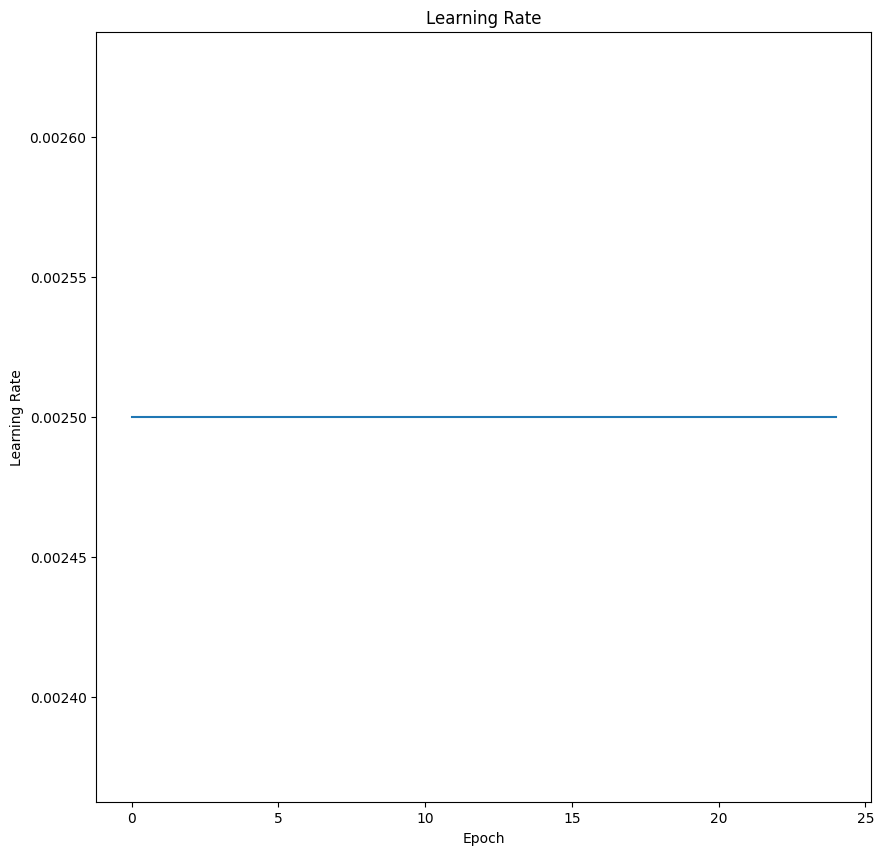

In [ ]:
model_runner.plot_lr_from_df()

In [12]:
model_runner.save_model_df('../results/dbpn/dataframes/DBPN-real-run-medium-dataset-lr-times-25-epoch=0-24.csv')
model_runner.save_model_weights(model, '../results/dbpn/dataframes/DBPN-real-run-medium-dataset-lr-times-25-epoch=0-24.pth')

In [13]:
# df = model_runner.load_df('../results/dbpn/dataframes/DBPN-real-run-medium-dataset-lr-times-50-epoch=0-24.csv')
# df
model_runner.get_model_df()

,epoch,time,lr,train_loss,validation_loss
0,0,454.305647,0.0025,1.888169e+20,4.687628e+15
1,1,454.144930,0.0025,2.257672e+15,9.920474e+14
2,2,454.211663,0.0025,4.937052e+14,1.543202e+14
3,3,454.182588,0.0025,1.217764e+14,7.200184e+13
4,4,454.003443,0.0025,5.885077e+13,3.725724e+13
5,5,453.967396,0.0025,2.800514e+13,1.491528e+13
6,6,453.902346,0.0025,1.222619e+13,7.390413e+12
7,7,453.762847,0.0025,6.869199e+12,3.813146e+12
8,8,453.799862,0.0025,3.428621e+12,1.587485e+12
9,9,453.495702,0.0025,1.639674e+12,8.597882e+11


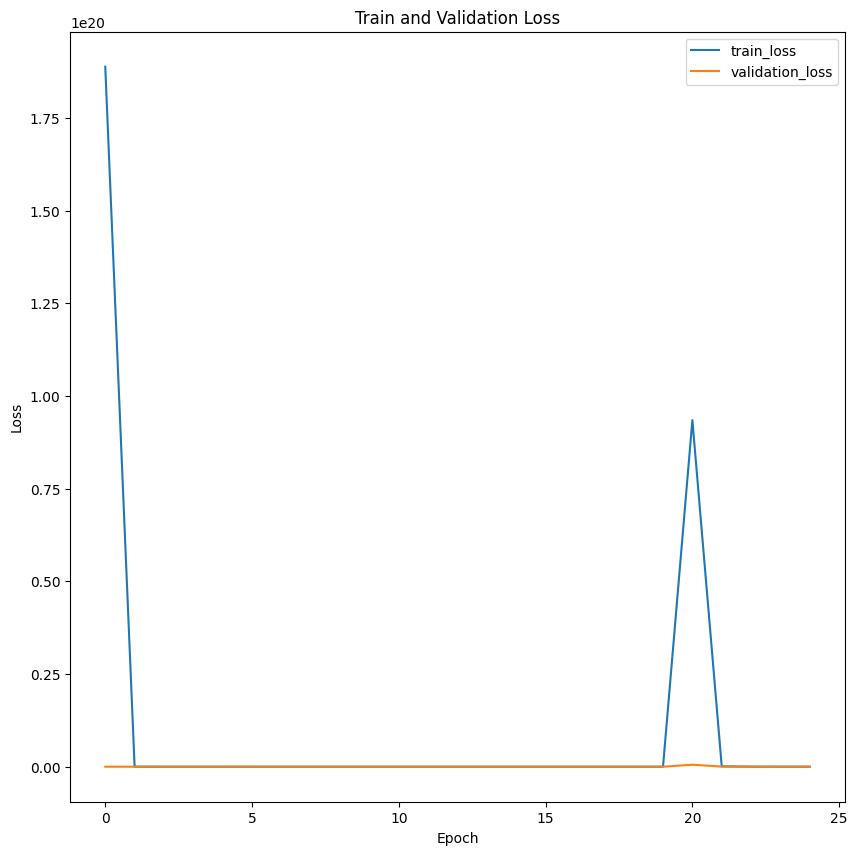

In [14]:
model_runner.plot_train_validation_loss_from_df(show_lr=False)

/home/pedrovelozo/TCC-Pedro-Velozo-ENG1132/env/lib/python3.8/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


should_upsample MUST ONLY BE `TRUE` for SRCNN


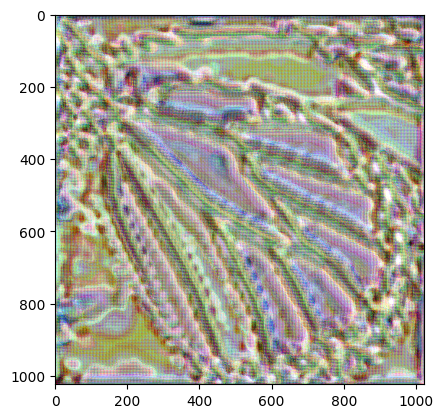

In [15]:
image_helper = ImageHelper()
image_helper.apply_model_to_image_and_show(
    model=model,
    image=f"../datasets/Set5/butterfly.png",
    downsample_factor=4,
    unsqueeze=True
)

In [19]:
model_runner = ModelRunner(device=device)
model_runner.compare_models(
    [
        {"name": "DBPN", "model": model,
                               "input_transform":lambda input: transforms.Compose([
                                 transforms.ToTensor(),
                                 transforms.Resize(
                                    (input.size[1] // 4, input.size[0] // 4), interpolation=Image.BICUBIC),
                                ])(input),
                                "should_only_downsampple": True, "scale":4, "unsqueeze": True },
    ],
    f"../datasets/BSDS100/", scale=4
)

0it [00:00, ?it/s]/home/pedrovelozo/TCC-Pedro-Velozo-ENG1132/env/lib/python3.8/site-packages/torchmetrics/utilities/prints.py:61: FutureWarning: Importing `PeakSignalNoiseRatio` from `torchmetrics` was deprecated and will be removed in 2.0. Import `PeakSignalNoiseRatio` from `torchmetrics.image` instead.
  _future_warning(
100it [00:03, 32.91it/s]
100it [00:01, 94.95it/s]


,PSNR,SSIM
DBPN,-150.240128,8.621222e-18
Bicubic,23.045410,6.328681e-01


In [29]:
model_runner = ModelRunner(device=device)
model_runner.compare_models(
    [
        {"name": "DBPN", "model": model,
                               "input_transform":lambda input: transforms.Compose([
                                 transforms.ToTensor(),
                                 transforms.Resize(
                                    (input.size[1] // 4, input.size[0] // 4), interpolation=Image.BICUBIC),
                                ])(input),
                                "should_only_downsampple": True, "scale":4, "unsqueeze": True },
    ],
    f"../datasets/BSDS100/", scale=4
)

0it [00:00, ?it/s]/home/pedrovelozo/TCC-Pedro-Velozo-ENG1132/env/lib/python3.8/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/home/pedrovelozo/TCC-Pedro-Velozo-ENG1132/env/lib/python3.8/site-packages/torchmetrics/utilities/prints.py:61: FutureWarning: Importing `PeakSignalNoiseRatio` from `torchmetrics` was deprecated and will be removed in 2.0. Import `P

,PSNR,SSIM
DBPN,24.850704,0.653421
Bicubic,23.045410,0.632868


In [9]:
model_2 = DBPN(num_channels=3, base_filter=64,  feat = 256, num_stages=7, scale_factor=4).to(device)
model_2.load_state_dict(torch.load('../results/dbpn/dataframes/DBPN-real-run-medium-dataset-lr-times-50-epoch=0-24.pth', map_location=torch.device('cpu')))

<All keys matched successfully>

In [11]:
model_runner.compare_models(
    [
        {"name": "DBPN", "model": model_2,
                               "input_transform":lambda input: transforms.Compose([
                                 transforms.ToTensor(),
                                 transforms.Resize(
                                    (input.size[1] // 4, input.size[0] // 4), interpolation=Image.BICUBIC),
                                ])(input),
                                "should_only_downsampple": True, "scale":4, "unsqueeze": True },
    ],
    f"../datasets/BSDS100/", scale=4
)

0it [00:00, ?it/s]/home/pedrovelozo/TCC-Pedro-Velozo-ENG1132/env/lib/python3.8/site-packages/torchmetrics/utilities/prints.py:61: FutureWarning: Importing `PeakSignalNoiseRatio` from `torchmetrics` was deprecated and will be removed in 2.0. Import `PeakSignalNoiseRatio` from `torchmetrics.image` instead.
  _future_warning(
100it [00:02, 34.28it/s]
100it [00:00, 100.20it/s]


,PSNR,SSIM
DBPN,-150.240128,8.621222e-18
Bicubic,23.045410,6.328681e-01


should_upsample MUST ONLY BE `TRUE` for SRCNN


/home/pedrovelozo/TCC-Pedro-Velozo-ENG1132/env/lib/python3.8/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


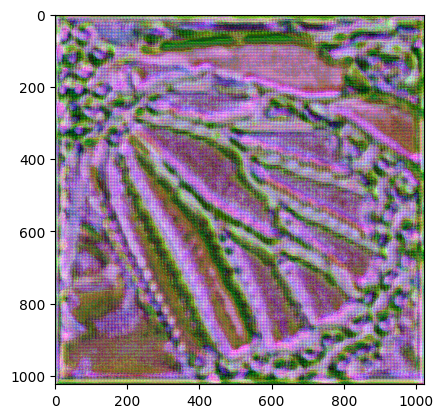

In [10]:
image_helper = ImageHelper()
image_helper.apply_model_to_image_and_show(
    model=model_2,
    image=f"../datasets/Set5/butterfly.png",
    downsample_factor=4,
    unsqueeze=True
)